In [1]:
# Notebook‑friendly PaSST fine‑tuning for emotion recognition
# -----------------------------------------------------------
# Each "# %%" cell marker lets Jupyter / VS Code split the notebook automatically.
# Adjust DATA_ROOT to point at your dataset folder containing
#   ├── train.csv / val.csv / test.csv
#   ├── train/*.wav / val/*.wav / test/*.wav
# 
# CSV format:  filename,emotion   where emotion ∈ {ANG, DIS, FEA, HAP, NEU, SAD}

# %% [markdown]
# ### 0  Setup & dependencies
# Make sure `hear21passt`, `torchaudio`, and `sklearn` are installed.
# If you use Google Colab, uncomment the next cell to install.
# !pip install hear21passt torchaudio scikit-learn tqdm matplotlib seaborn --quiet

In [2]:
# %%
import os, random, time, csv
from pathlib import Path
from typing import List, Tuple

import torch, torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from hear21passt.base import get_model_passt

torch.backends.cudnn.benchmark = True


/home/vm-user/anaconda3/envs/passt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# %% [markdown]
# ### 1  Reproducibility helpers
# %%

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

set_seed(42)

In [5]:
# %% [markdown]
# ### 2  Constants & label maps
# %%

In [6]:
EMOTIONS = ["ANG", "DIS", "FEA", "HAP", "NEU", "SAD"]
LABEL_MAP  = {e: i for i, e in enumerate(EMOTIONS)}
INV_LABEL  = {i: e for e, i in LABEL_MAP.items()}
TARGET_SR   = 32_000
NUM_SAMPLES = 1024 + (998 - 1) * 320   # 10.002 s @ 32 kHz
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", DEVICE)

Using cuda


In [7]:
# %% [markdown]
# ### 3  Dataset with on‑the‑fly augmentation
# %%

In [8]:
class EmotionDataset(Dataset):
    """Return mel‑spectrogram tensors (1×128×998) + label."""
    def __init__(self, csv_path: Path, audio_root: Path, augment=False):
        self.records: List[Tuple[Path, int]] = []
        with open(csv_path, newline="") as f:
            for row in csv.DictReader(f):
                emo = row["emotion"].strip().upper()
                if emo in LABEL_MAP:
                    self.records.append((audio_root / row["filename"].strip(), LABEL_MAP[emo]))
        if not self.records:
            raise ValueError("CSV parsing failed—no usable rows")
        self.augment = augment
        self.resample = T.Resample(TARGET_SR, TARGET_SR)
        self.mel = T.MelSpectrogram(sample_rate=TARGET_SR, n_fft=1024, hop_length=320, n_mels=128, center=False)
        self.db  = T.AmplitudeToDB("power")
        self.pitch_fn = lambda w: T.PitchShift(TARGET_SR, n_steps=random.uniform(-2,2))(w)
        self.gain_fn  = lambda w: T.Vol(gain=random.uniform(-6,6), gain_type="db")(w)

    def __len__(self): return len(self.records)

    def _augment(self, w):
        if random.random()<0.5: w += torch.randn_like(w)*0.005
        if random.random()<0.3: w = self.gain_fn(w)
        if random.random()<0.2: w = self.pitch_fn(w)
        return w

    def __getitem__(self, idx):
        path, label = self.records[idx]
        w, sr = torchaudio.load(path)
        if w.shape[0]>1: w=w.mean(0, keepdim=True)
        if sr!=TARGET_SR: w=self.resample(w)
        if self.augment: w=self._augment(w)
        w = (w-w.mean())/(w.std()+1e-9)
        mel = self.db(self.mel(w)).clamp(min=-80.0)
        if mel.shape[2]<998: mel=F.pad(mel,(0,998-mel.shape[2]))
        else: mel=mel[...,:998]
        return mel, label


In [9]:

# %% [markdown]
# ### 4  Paths & data loaders
# Adjust `DATA_ROOT` to your dataset location.
# %%

In [10]:
DATA_ROOT = Path("/home/vm-user/Documents/lucky/dataset")  # <- change this!
BATCH = 3                  # reduced for 8 GB GPUs
ACC_STEPS = 2                # accumulate gradients to simulate bigger batch

train_ds = EmotionDataset(DATA_ROOT/"train.csv", DATA_ROOT/"train", augment=True)
val_ds   = EmotionDataset(DATA_ROOT/"val.csv",   DATA_ROOT/"val")

test_ds  = EmotionDataset(DATA_ROOT/"test.csv",  DATA_ROOT/"test")
collate  = lambda b: (torch.stack([x for x,_ in b]), torch.tensor([y for _,y in b]))
train_loader=DataLoader(train_ds,BATCH,True, drop_last=True, collate_fn=collate, pin_memory=True)
val_loader  =DataLoader(val_ds  ,BATCH,False,                collate_fn=collate, pin_memory=True)
print(len(train_ds),"train samples •",len(val_ds),"val •",len(test_ds),"test")


5209 train samples • 1116 val • 1117 test


In [11]:
# %% [markdown]
# ### 5  Model: PaSST S‑SWA with new 6‑class head
# We fine‑tune only the last transformer block and the classification MLp head.
# %%

In [12]:
model = get_model_passt("passt_s_swa_p16_128_ap476", pretrained=True, n_classes=len(EMOTIONS)).to(DEVICE)
for n,p in model.named_parameters():
    p.requires_grad = n.startswith("blocks.11") or n.startswith("mlp_head")
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6, "M")



 Loading PASST TRAINED ON AUDISET 




/home/vm-user/anaconda3/envs/passt/lib/python3.8/site-packages/hear21passt/models/helpers/vit_helpers.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch

PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
     

In [13]:
#from torch import amp
#from torch.cuda.amp import autocast

#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5, weight_decay=1e-2)

#scaler = amp.GradScaler(device='cuda')  # updated per warning

# Enable patchout during training to save memory
#model.train_patchout = True
#model.train_patchout_t = 10  # drop 10 time patches
#model.train_patchout_f = 4   # drop 4 freq patches


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=3e-5, weight_decay=1e-2)
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

# enable patchout during training to save memory
model.train_patchout = True
model.train_patchout_t = 10  # drop 10 time patches
model.train_patchout_f = 4   # drop 4 freq patches


/tmp/ipykernel_3109506/2369042697.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [14]:
# %% [markdown]
# ### 6  Training & validation helpers
# %%

In [15]:
def one_epoch():
    model.train(); running=0
    optimizer.zero_grad()
    for i,(xb,yb) in enumerate(train_loader):
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        with autocast():
            logits = model(xb)
        if isinstance(logits, tuple):  # PaSST may return (logits, dist_logits)
            logits = logits[0]
        loss = criterion(logits, yb) / ACC_STEPS
        scaler.scale(loss).backward()
        if (i+1)%ACC_STEPS==0:
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
        running += loss.item()*ACC_STEPS*xb.size(0)
    return running/len(train_loader.dataset)

def evaluate(loader):
    model.eval(); yt,yp=[],[]
    with torch.no_grad(), autocast():
        for xb,yb in loader:
            out = model(xb.to(DEVICE))
            if isinstance(out, tuple):
                out = out[0]
            preds = out.argmax(1).cpu()
            yt+=yb.tolist(); yp+=preds.tolist()
    return f1_score(yt,yp,average="weighted"), yt, yp

In [16]:
# %% [markdown]
# ### 7  Training loop
# %%


In [17]:
EPOCHS=20; best=0
for ep in range(1,EPOCHS+1):
    tloss=one_epoch()
    f1,_,_ = evaluate(val_loader)
    print(f"Epoch {ep:02d}: loss {tloss:.4f}  val‑F1 {f1:.4f}")
    if f1>best:
        torch.save(model.state_dict(),"best_passt_emotion.pt"); best=f1; print("📝 new best saved")

/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


x torch.Size([3, 1, 128, 998])
self.norm(x) torch.Size([3, 768, 12, 99])
 patch_embed :  torch.Size([3, 768, 12, 99])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([3, 1188, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([3, 1, 768])
 self.dist_token.shape torch.Size([3, 1, 768])
 final sequence x torch.Size([3, 1190, 768])
 after 12 atten blocks x torch.Size([3, 1190, 768])
forward_features torch.Size([3, 768])
head torch.Size([3, 6])


/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 01: loss 1.5315  val‑F1 0.3913
📝 new best saved


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 02: loss 1.3916  val‑F1 0.4003
📝 new best saved


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 03: loss 1.3278  val‑F1 0.4295
📝 new best saved


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 04: loss 1.2850  val‑F1 0.4746
📝 new best saved


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 05: loss 1.2417  val‑F1 0.4820
📝 new best saved


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 06: loss 1.2136  val‑F1 0.4812


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 07: loss 1.1746  val‑F1 0.4990
📝 new best saved


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 08: loss 1.1464  val‑F1 0.4809


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 09: loss 1.1198  val‑F1 0.4744


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 10: loss 1.0870  val‑F1 0.5063
📝 new best saved


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 11: loss 1.0557  val‑F1 0.4900


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 12: loss 1.0280  val‑F1 0.4908


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 13: loss 1.0054  val‑F1 0.4816


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 14: loss 0.9703  val‑F1 0.5034


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 15: loss 0.9560  val‑F1 0.4858


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 16: loss 0.9245  val‑F1 0.5043


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 17: loss 0.8839  val‑F1 0.4719


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 18: loss 0.8552  val‑F1 0.4868


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 19: loss 0.8014  val‑F1 0.4858


/tmp/ipykernel_3109506/527496067.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3109506/527496067.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 20: loss 0.7793  val‑F1 0.4898


In [18]:
# %% [markdown]
# ### 8  Load best checkpoint & final test metrics
# %%

/tmp/ipykernel_3109506/1290569092.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_passt_emotion.pt", map_location=DEVICE))
/tmp/ip

Test weighted‑F1: 0.5204996199360076
              precision    recall  f1-score   support

         ANG     0.6340    0.7801    0.6995       191
         DIS     0.4061    0.4869    0.4429       191
         FEA     0.4938    0.4211    0.4545       190
         HAP     0.5929    0.4346    0.5015       191
         NEU     0.5255    0.4417    0.4800       163
         SAD     0.5093    0.5707    0.5383       191

    accuracy                         0.5246      1117
   macro avg     0.5270    0.5225    0.5195      1117
weighted avg     0.5270    0.5246    0.5205      1117



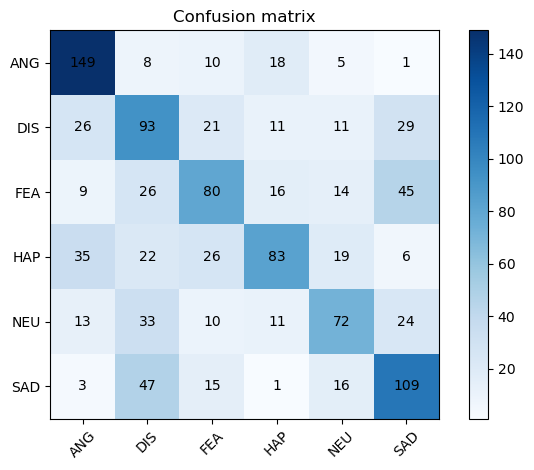

In [19]:
model.load_state_dict(torch.load("best_passt_emotion.pt", map_location=DEVICE))
f1, y_true, y_pred = evaluate(DataLoader(test_ds, batch_size=BATCH, collate_fn=collate))
print("Test weighted‑F1:", f1)
print(classification_report(y_true, y_pred, target_names=EMOTIONS, digits=4))
cm=confusion_matrix(y_true,y_pred)
plt.imshow(cm,cmap="Blues"); plt.title("Confusion matrix"); plt.colorbar()
plt.xticks(range(6),EMOTIONS,rotation=45); plt.yticks(range(6),EMOTIONS)
for i in range(6):
    for j in range(6):
        plt.text(j,i,cm[i,j],ha="center",va="center")
plt.tight_layout(); plt.show()
